**Topic:**        Project Benson   
**Subject:**      Explore MTA turnstile data  
**Date:**         07/03/2018  
**Name:**         Auste Mastaviciute  
**Worked with:**  Billy, Chelan, Alan, Joyce, Xu

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [61]:
from datetime import datetime as dt
import datetime
import dateutil.parser

In [62]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 3)

**Import Data from MTA website**

In [63]:
def fix_time(num):
    if len(str(num)) == 2:
        return str(num)
    else:
        return '0'+str(num)

def get_week_nums(month,yrs_back):
    week_list = []
    ref_date = datetime.date(2018,6,30)
    weeks_back = yrs_back * 52
    for i in range(weeks_back):
        week_shift = datetime.timedelta(-7 * i)
        new = ref_date + week_shift
        yr = str(new.year)[-2:]
        mt = fix_time(new.month)
        day = fix_time(new.day)
        string = yr + mt + day
        if int(mt) == month:
            week_list.append(int(string))
    return week_list

In [64]:
def scrape(week_nums):
    """Gets the data from MTA website and loads it into a pandas DataFrame"""
    url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

week_nums = get_week_nums(6, 1)
turnstiles_df = scrape(week_nums)
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,00:00:00,REGULAR,6667150,2259901
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,04:00:00,REGULAR,6667173,2259909
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,08:00:00,REGULAR,6667189,2259938
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,12:00:00,REGULAR,6667305,2260006
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,06/23/2018,16:00:00,REGULAR,6667534,2260066


**Data Formating**

In [65]:
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [66]:
#Trim the names of the columns from all the unneccesary white space
turnstiles_df.columns = turnstiles_df.columns.str.strip()
turnstiles_df.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [67]:
#Merge the DATE and TIME columns and format as DateTime rather than string
turnstiles_df['DATETIME'] = pd.to_datetime(turnstiles_df['DATE'] +' '+ turnstiles_df['TIME'], infer_datetime_format=True)


In [68]:
#Add WEEKDAY column
turnstiles_df['WEEKDAY'] = turnstiles_df['DATETIME'].dt.weekday_name
#turnstiles_df.head()


## Data Exploration & Cleaning

In [69]:
#Check for duplicates
duplicate_check = turnstiles_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME']).EXITS.count().reset_index().sort_values(by='EXITS', ascending = False)
#print(duplicate_check.head(5),'\n')

duplicate_count = duplicate_check[duplicate_check['EXITS'] > 1]['STATION'].count()
#print(duplicate_count)
print('The dataset had', str(duplicate_count), 'duplicated values for station & datetime pairs, which we will remove in the next step')


The dataset had 1 duplicated values for station & datetime pairs, which we will remove in the next step


In [70]:
#Remove duplicates
turnstiles_df.sort_values(['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME'], inplace = True, ascending = False)
turnstiles_df.drop_duplicates(subset = ['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME'], inplace = True)

#Check if duplicates are gone
duplicate_double_check = turnstiles_df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'WEEKDAY','DATETIME']).EXITS.count().reset_index().sort_values(by='EXITS', ascending = False)
final_duplicates = duplicate_double_check[duplicate_double_check['EXITS'] > 1]['STATION'].count()
remaining = 'All' if final_duplicates == 0 else str(final_duplicates)

print(str(remaining), 'duplicates have been removed')

All duplicates have been removed


**Explore the different time intervals**

Text(0,0.5,'Frequency')

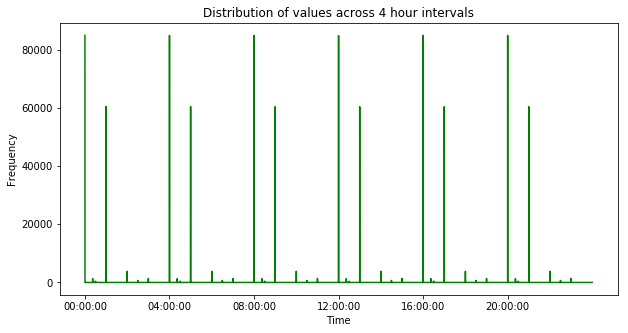

In [71]:
#Understand the distribution among different times
time_dist = turnstiles_df.groupby([turnstiles_df['DATETIME'].dt.time])['EXITS'].count().sort_values(ascending=False)
time_dist.plot(figsize = (10, 5), xticks = ['00:00:00', '04:00:00', '08:00:00', '12:00:00', '16:00:00', '20:00:00'], color='g')
plt.title('Distribution of values across 4 hour intervals')
plt.xlabel('Time')
plt.ylabel('Frequency')

**Explore the stations with non-zero hour records**

In [72]:
non_exact_hour_df = turnstiles_df[(turnstiles_df['DATETIME'].dt.minute != 0) | (turnstiles_df['DATETIME'].dt.second != 0)]

print(non_exact_hour_df.groupby(['DIVISION'])['EXITS'].count().sort_values(ascending = False))
print('\nMost (in this example - 74%) of the records are coming from PTH division, which is in New Jersey')

DIVISION
PTH    63048
IND    10987
IRT     5490
BMT      566
RIT        6
Name: EXITS, dtype: int64

Most (in this example - 74%) of the records are coming from PTH division, which is in New Jersey


**Remove New Jersey (PTH) stations**

In [73]:
print('Number of stations before dropping PTH division was', str(len(turnstiles_df['STATION'].unique())))

turnstile_no_PTH = turnstiles_df[turnstiles_df['DIVISION'] != 'PTH']
#turnstile_no_PTH[turnstile_no_PTH['DIVISION'] == 'PTH']['STATION'].count()

total_records = turnstiles_df['DATETIME'].count()
total_no_PTH_records = turnstile_no_PTH['DATETIME'].count()

print('Number of stations after dropping PTH division was', str(len(turnstile_no_PTH['STATION'].unique())))
print('Number stations dropped as New Jersey stations is', str(len(turnstiles_df['STATION'].unique()) - len(turnstile_no_PTH['STATION'].unique()))+'.')

print(str(round(((total_records - total_no_PTH_records) / total_no_PTH_records) * 100, 0))+ '% of all records have been excluded as New Jersey data.')

Number of stations before dropping PTH division was 377
Number of stations after dropping PTH division was 359
Number stations dropped as New Jersey stations is 18.
7.0% of all records have been excluded as New Jersey data.


**Explore remaining non-exact hours records**

In [74]:
#Quantify how many records there are with non-zero minute:second pairs
exact_hour = turnstile_no_PTH['STATION'][(turnstile_no_PTH['DATETIME'].dt.minute == 0) & (turnstile_no_PTH['DATETIME'].dt.second == 0)].count()
non_exact_hour = turnstile_no_PTH['STATION'][(turnstile_no_PTH['DATETIME'].dt.minute != 0) | (turnstile_no_PTH['DATETIME'].dt.second != 0)].count()

print('Number of stations with minutes equal to zero:', exact_hour)
print('Number of stations with minutes not equal to zero:', non_exact_hour)
print(str(round((non_exact_hour / (exact_hour + non_exact_hour)) * 100, 0))+ '% of records were not recorded at exact hour.')

Number of stations with minutes equal to zero: 903629
Number of stations with minutes not equal to zero: 17049
2.0% of records were not recorded at exact hour.


In [75]:
print('Number of stations before cleaning non-exact hour records is', str(len(turnstile_no_PTH['STATION'].unique()))+'.')

#Remove timestamps with non-zero minutes and seconds
turnstiles_clean = turnstile_no_PTH[(turnstile_no_PTH['DATETIME'].dt.minute == 0) & (turnstile_no_PTH['DATETIME'].dt.second == 0)]
print('Number of stations after cleaning non-exact hour records is', str(len(turnstiles_clean['STATION'].unique()))+'.')

excluded = turnstile_no_PTH[(turnstile_no_PTH['DATETIME'].dt.minute != 0) | (turnstile_no_PTH['DATETIME'].dt.second != 0)]
incl_stations = turnstiles_clean['STATION'].unique()
excl_stations = excluded['STATION'].unique()
num_stations_excl = len(turnstile_no_PTH['STATION'].unique()) - len(turnstiles_clean['STATION'].unique())

def dropped_stations(incl_stations, excl_stations):
    """Takes the list of included stations and list of excluded stations.
    Returns the stations that have been completely droped"""
    dropped_stations = []
    for station in excl_stations:
        if station not in incl_stations:
            dropped_stations.append(station)
    return dropped_stations

print('The following', str(num_stations_excl), 'stations have been excluded from the dataset:', str(dropped_stations(incl_stations, excl_stations)))        

Number of stations before cleaning non-exact hour records is 359.
Number of stations after cleaning non-exact hour records is 356.
The following 3 stations have been excluded from the dataset: ['161/YANKEE STAD', '15 ST-PROSPECT', 'KEW GARDENS']


**Understand if the excluded stations are significant**

In [76]:
dropped_st = turnstile_no_PTH.loc[turnstile_no_PTH['STATION'].isin(['KEW GARDENS', '161/YANKEE STAD', '15 ST-PROSPECT'])]
#dropped_st.head()

#161/YANKEE STAD station consistently has the records every 4 hours (starting midnight) and 22 minutes
#15 ST-PROSPECT and KEW GARDENS stations consistently has the records every 4 hours (starting midnight) and 30 minutes

#Should probably leave these stations in, since they are recorded at a legitimate 4h period

print('The', str(num_stations_excl), 'stations that were being excluding through non-exact hour cleaning process proved to be valuable and therefore will be included in our analysis.')

The 3 stations that were being excluding through non-exact hour cleaning process proved to be valuable and therefore will be included in our analysis.


In [77]:
#Sort the data frame by DATETIME column
turnstile_no_PTH = turnstile_no_PTH.sort_values(by = ['STATION', 'DATETIME'])
#turnstile_no_PTH.head(15)

#Add two new columns with Previous Datetime a record was taken and the actual record in PREV_EXITS
turnstile_no_PTH['PREV_DATETIME'] = turnstile_no_PTH['DATETIME'].shift()
turnstile_no_PTH['PREV_EXITS'] = turnstile_no_PTH['EXITS'].shift()
#turnstile_no_PTH.head()

#Add EXITS_DIFF column - Transform the Exits column from accummulative to actual per time period
turnstile_no_PTH['EXITS_DIFF'] = turnstile_no_PTH['EXITS'].sub(turnstile_no_PTH['PREV_EXITS'])
turnstile_no_PTH.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,WEEKDAY,PREV_DATETIME,PREV_EXITS,EXITS_DIFF
30357,H008,R248,01-00-04,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,1628762048,167915080,2018-05-26,Saturday,NaT,NaN,NaN
30315,H008,R248,01-00-03,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,954634557,998241965,2018-05-26,Saturday,2018-05-26,1.679e+08,8.303e+08
30273,H008,R248,01-00-02,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,136039,291608,2018-05-26,Saturday,2018-05-26,9.982e+08,-9.980e+08
30231,H008,R248,01-00-01,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,2528854,14455422,2018-05-26,Saturday,2018-05-26,2.916e+05,1.416e+07
30189,H008,R248,01-00-00,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,202358,3017350,2018-05-26,Saturday,2018-05-26,1.446e+07,-1.144e+07


**Drop NaN values**

In [78]:
#Remove rows with NaN values in previous exits column
turnstile_no_PTH = turnstile_no_PTH.drop(['EXITS_DIFF'], axis=0).dropna()
turnstile_no_PTH.head()


,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,WEEKDAY,PREV_DATETIME,PREV_EXITS,EXITS_DIFF
30315,H008,R248,01-00-03,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,954634557,998241965,2018-05-26,Saturday,2018-05-26,1.679e+08,8.303e+08
30273,H008,R248,01-00-02,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,136039,291608,2018-05-26,Saturday,2018-05-26,9.982e+08,-9.980e+08
30231,H008,R248,01-00-01,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,2528854,14455422,2018-05-26,Saturday,2018-05-26,2.916e+05,1.416e+07
30189,H008,R248,01-00-00,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,202358,3017350,2018-05-26,Saturday,2018-05-26,1.446e+07,-1.144e+07
30147,H007,R248,00-03-02,1 AV,L,BMT,05/26/2018,00:00:00,REGULAR,6001834,503962,2018-05-26,Saturday,2018-05-26,3.017e+06,-2.513e+06


**Shorten the DataFrame**

In [3]:
turnstile_short = turnstile_no_PTH.groupby(['STATION', 'WEEKDAY','DATETIME'])['EXITS_DIFF'].sum()
turnstile_short = turnstile_short.reset_index()
turnstile_short.head(10)

NameError: name 'turnstile_no_PTH' is not defined

**Converting all EXITS_DIFF to positive values**

In [2]:
turnstile_short['EXITS_DIFF'] = abs(turnstile_short['EXITS_DIFF'])
turnstile_short.head()

NameError: name 'turnstile_short' is not defined

In [ ]:
#Explore the distribution of EXITS_DIFF column
turnstile_short['EXITS_DIFF'].plot(title = 'Absolute Number of Exits Distribution', figsize = (10, 5), color = 'c')
plt.xlabel('Records per station & Date-Time pair')
plt.ylabel('Exits')


Text(0,0.5,'Exits')

**Remove the extreme values and outliers**

In [1]:
turnstile_less_mln = turnstile_short.copy()
#turnstile_less_mln.head()

new_exits_mln = turnstile_less_mln.loc[turnstile_less_mln['EXITS_DIFF'] < 1 * 10**6]['EXITS_DIFF']
plt.figure(figsize = (10, 5))
plt.hist(new_exits_mln, bins=np.arange(0, 3 * 10**5, 30), color='m')
plt.title('Exits distribution per 4 hour interval')
plt.xlabel('Exits (limit = 300k)')
plt.ylabel('Frequency (log)')
plt.show()

NameError: name 'turnstile_short' is not defined

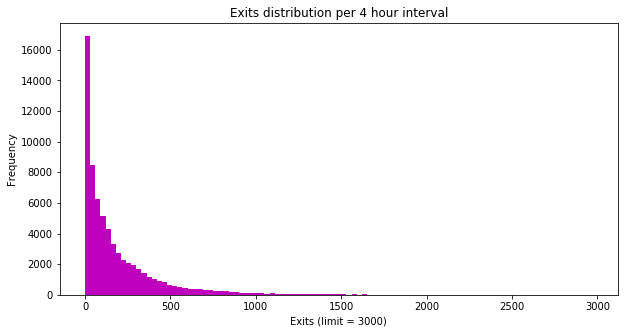

In [83]:
#Normal y-scale with limit of 3000
plt.figure(figsize = (10, 5))
plt.hist(new_exits_mln, bins=np.arange(0, 3 * 10**3, 30), color='m')
plt.title('Exits distribution per 4 hour interval')
plt.xlabel('Exits (limit = 3000)')
plt.ylabel('Frequency')
plt.show()